In [1]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")
sys.path.append("/Library/Python/3.7/site-packages")

In [2]:
import numpy as np
import meep as mp
from autograd import numpy as npa
import meep.adjoint as mpa
from matplotlib import pyplot as plt

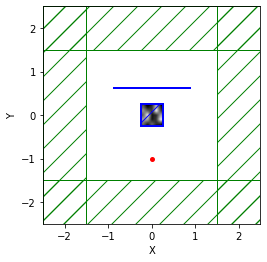

Starting forward run...
Starting adjoint run...
Calculating gradient...


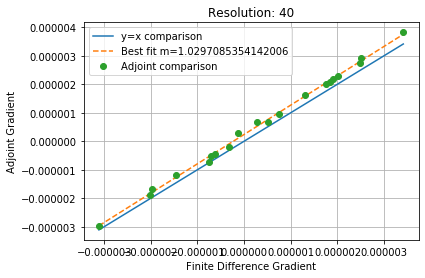

In [3]:
mp.quiet(quietval=True)
seed = 24
#np.random.seed(seed)

resolution = 40

Sx = 5
Sy = 5
sxy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [0,-1,0]
source_size    = mp.Vector3(0,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)

source = [mp.Source(src,component=mp.Ex,
                    size = source_size,
                    center=source_center)]


design_region_resolution = 10

Nx = design_region_resolution//2
Ny = design_region_resolution//2

Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_SUM')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(0.5, 0.5, 0)))




geometry = [
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)# design region
]


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

far_x = mp.Vector3(2000, 2000, 0)
NearRegions = [mp.Near2FarRegion(center=mp.Vector3(0,+0.125*sxy), size=mp.Vector3(0.35*sxy,0), weight=+1)]


Far0 = mpa.Far_Coefficients(sim, NearRegions ,far_x)


ob_list = [Far0]




def J2(alpha):
    return npa.abs(alpha[0,0])**2 + npa.abs(alpha[1,5])**3


def J1(alpha):
    return npa.abs(alpha[0,0])**2


def J3(alpha):
    return npa.abs(alpha[0,0])**2 + npa.abs(alpha[0,5])**3




opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J1,
    objective_arguments=ob_list,
    design_regions=[design_region],
    #design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ex]
)




x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])



opt.plot2D(True,frequency=1/1.55)
plt.show()



f0, dJ_deps = opt()



db = 1e-3
choose = 20

g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

#g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)

g_adjoint = dJ_deps
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()







In [4]:
Far0_2 = np.zeros((1,6), dtype='complex128')

Ex2 = sim.get_dft_array(Far0.monitor, mp.Ex, 0)
Hz2 = sim.get_dft_array(Far0.monitor, mp.Hz, 0)
countE, countH = 0, 0
for near_data in Far0.all_near_data:
    near_pt = near_data.near_x
    if near_data.near_fd_comp == mp.Ex:
        Far0_2 += np.array(near_data.matrix_elt)*Ex2[countE]/40
        countE+=1
    elif near_data.near_fd_comp == mp.Hz:
        Far0_2 += np.array(near_data.matrix_elt)*Hz2[countH//2]/80
        countH+=1

print(Far0_2/Far0())
print(countH, countE)
print(Hz2.shape, Ex2.shape)






[[0.92207291-0.02199427j 0.92204376-0.0219257j         nan       +nanj
         nan       +nanj        nan       +nanj 0.92205832-0.02195998j]]
144 72
(72,) (72,)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Starting forward run...
Starting adjoint run...
Calculating gradient...


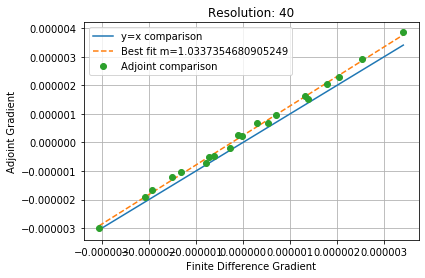

[[0.92195777-0.02145268j 0.92192937-0.02138389j        nan       +nanj
         nan       +nanj        nan       +nanj 0.92194355-0.02141828j]]
144 72
(72,) (72,)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [5]:

opt.objective_functions=[J3]

f0, dJ_deps = opt()



db = 1e-3
choose = 20

g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

#g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)

g_adjoint = dJ_deps
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()




Far0_2 = np.zeros((1,6), dtype='complex128')

Ex2 = sim.get_dft_array(Far0.monitor, mp.Ex, 0)
Hz2 = sim.get_dft_array(Far0.monitor, mp.Hz, 0)
countE, countH = 0, 0
for near_data in Far0.all_near_data:
    near_pt = near_data.near_x
    if near_data.near_fd_comp == mp.Ex:
        Far0_2 += np.array(near_data.matrix_elt)*Ex2[countE]/40
        countE+=1
    elif near_data.near_fd_comp == mp.Hz:
        Far0_2 += np.array(near_data.matrix_elt)*Hz2[countH//2]/80
        countH+=1

print(Far0_2/Far0())
print(countH, countE)
print(Hz2.shape, Ex2.shape)

Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.7/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)
/usr/local/lib/python3.7/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: invalid value encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)


Calculating gradient...


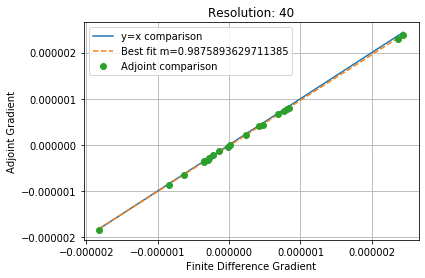

[[0.93487141+0.05685128j 0.9349359 +0.05687682j        nan       +nanj
         nan       +nanj        nan       +nanj 0.93490367+0.05686407j]
 [0.92186651-0.02088594j 0.92183889-0.02081697j        nan       +nanj
         nan       +nanj        nan       +nanj 0.92185268-0.02085145j]
 [0.89663176-0.00955688j 0.89663324-0.00944781j        nan       +nanj
         nan       +nanj        nan       +nanj 0.89663247-0.00950233j]]
144 72
(3, 72) (3, 72)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


In [6]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J2,
    objective_arguments=ob_list,
    design_regions=[design_region],
    #design_variables=[design_variables],
    fcen=fcen,
    df = 0.03,
    nf = 3,
    decay_fields=[mp.Ex]
)


f0, dJ_deps = opt()



db = 1e-3
choose = 20

g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)


g_adjoint = np.sum(dJ_deps, axis=1)
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()


Far0_2 = np.zeros((3,6), dtype='complex128')

Ex2 = np.array([sim.get_dft_array(Far0.monitor, mp.Ex, i) for i in range(3)])
Hz2 = np.array([sim.get_dft_array(Far0.monitor, mp.Hz, i) for i in range(3)])

countE, countH = 0, 0
for near_data in Far0.all_near_data:
    near_pt = near_data.near_x
    if near_data.near_fd_comp == mp.Ex:
        Far0_2 += np.array(near_data.matrix_elt)*np.reshape(Ex2[:,countE], (-1, 1))/40
        countE+=1
    elif near_data.near_fd_comp == mp.Hz:
        Far0_2 += np.array(near_data.matrix_elt)*np.reshape(Hz2[:,countH//2],(-1,1))/80
        countH+=1

print(Far0_2/Far0())
print(countH, countE)
print(Hz2.shape, Ex2.shape)